# UCCSD ansatz, L-BFGS-B optimizer, Jordan-Wigner mapping, Aer simulator

    \item circuit depth,
    \item gate fidelity,
    \item parameter count,
    \item TRAINABILITY,
    \item EXPRESSIBILITY.

    $H_2$, $He$, $LiH$, $BeH_2$ molecules.

In [3]:
from lib.utils import h_and_uccsd
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator
import numpy as np
from matplotlib import pyplot as plt
import time

In [6]:
molecules = [
    ("H2", lambda d: f"H .0 .0 .0; H .0 .0 {d}"),
    ("LiH", lambda d: f"Li .0 .0 .0; H .0 .0 {d}"),
    ("BeH2", lambda d: f"Be .0 .0 .0; H .0 .0 {d}; H .0 .0 {-d}"),
]
mapper = "JW"
optimizer = L_BFGS_B(tol=1e-5) # maxiter=1000
estimator = StatevectorEstimator()


# for name, geom_fn in molecules:
#     geom = geom_fn(0.735)

## $H_2$


In [23]:
distances=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]
iterations = [[] for _ in range(len(distances))]
runtimes=[]
energies=[]
fci_runtimes=[]
fci_energies=[]

In [24]:
for i in range(len(distances)):
    (qubit_hamiltonian, ansatz) = h_and_uccsd(mapper="JW", molecule_string=molecules[0][1](distances[i]))
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        iterations[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    start = time.perf_counter()
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    end = time.perf_counter()
    runtimes.append(end - start)
    energies.append(result.fun)

In [25]:
# FCI
from lib.utils import get_fci_h2

for i in range(len(distances)):
    start = time.perf_counter()
    fci_energy = get_fci_h2(distances[i])
    end = time.perf_counter()
    fci_runtimes.append(end - start)
    fci_energies.append(fci_energy)

converged SCF energy = 2.71588739329275
converged SCF energy = 0.164175012061695
converged SCF energy = -1.04299627454009
converged SCF energy = -1.116998996754
converged SCF energy = -1.06610864931794
converged SCF energy = -0.910873554594387
converged SCF energy = -0.783792654277353
converged SCF energy = -0.656048251145591
converged SCF energy = -0.614869974042561


[-2.581811338332701, -2.4884039198016166, -2.113514216310601, -1.857275030202349, -1.6303275411525613, -1.3509341607512477, -1.2132297176356228, -1.1100242481589517, -1.0654656645440537]
[np.float64(2.709960770867275), np.float64(0.1574821347983626), np.float64(-1.0551597944706266), np.float64(-1.1373060357534004), np.float64(-1.1011503302326187), np.float64(-0.9981493534714101), np.float64(-0.9486411121761855), np.float64(-0.9336318445584986), np.float64(-0.9331713618436487)]


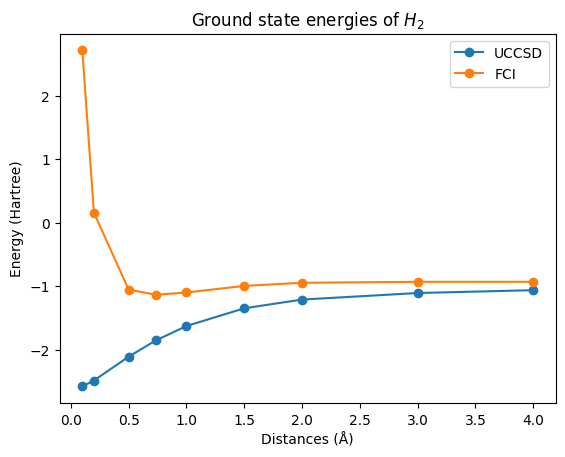

In [26]:
print(energies)
print(fci_energies)
plt.plot(distances, energies, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_energies, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()

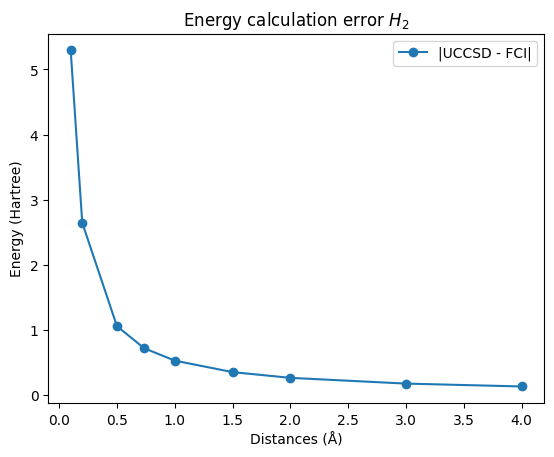

In [27]:
plt.plot(distances, [abs(e - f) for e, f in zip(energies, fci_energies)], marker='o', linestyle='-', label="|UCCSD - FCI|")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy calculation error $H_2$')
plt.show()

[[array(-2.57588472), array(-2.57588472), array(-2.57588472), array(-2.57588471), array(0.19176695), array(0.19176695), array(0.19176695), array(0.19176691), array(-2.58163752), array(-2.58163752), array(-2.58163752), array(-2.58163752), array(-2.58181134), array(-2.58181134), array(-2.58181134), array(-2.58181134), array(-2.58181134), array(-2.58181134), array(-2.58181134), array(-2.58181134)], [array(-2.48171104), array(-2.48171104), array(-2.48171104), array(-2.48171104), array(0.01006155), array(0.01006155), array(0.01006155), array(0.01006152), array(-2.48820939), array(-2.48820939), array(-2.48820939), array(-2.48820939), array(-2.48840392), array(-2.48840392), array(-2.48840392), array(-2.48840392), array(-2.48840392), array(-2.48840392), array(-2.48840392), array(-2.48840392)], [array(-2.1013507), array(-2.1013507), array(-2.1013507), array(-2.10135069), array(-0.60345123), array(-0.60345123), array(-0.60345123), array(-0.60345125), array(-2.11318414), array(-2.11318414), array

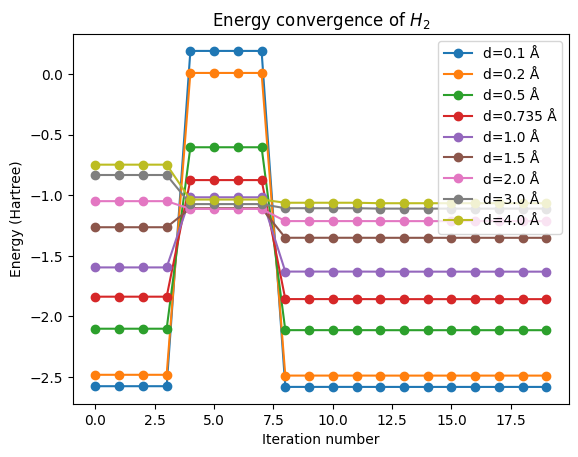

In [29]:
print(iterations)
for i in range(len(distances)):
    plt.plot(range(len(iterations[i])), iterations[i], marker='o', linestyle='-', label=f'd={distances[i]} Å')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Energy (Hartree)')
plt.title('Energy convergence of $H_2$')
plt.show()

[0.12952407699776813, 0.1197768050187733, 0.11400804898585193, 0.12197749098413624, 0.11859144299523905, 0.12908469900139607, 0.11893639198387973, 0.11636234397883527, 0.11750166999991052]
[0.10744974497356452, 0.09115458000451326, 0.057471139007247984, 0.08491390399285592, 0.035672687023179606, 0.056222457002149895, 0.054380237008444965, 0.047080445976462215, 0.04863502498483285]


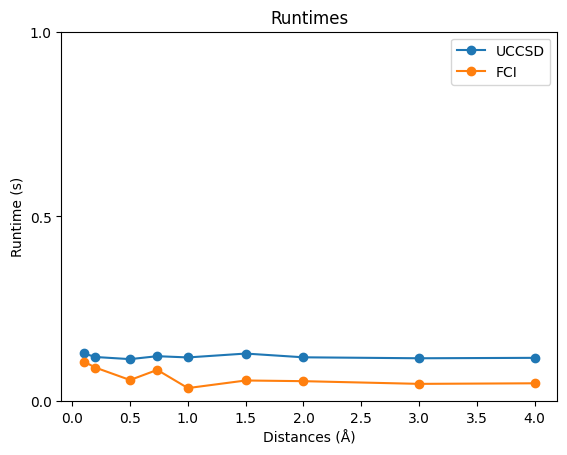

In [30]:
print(runtimes)
print(fci_runtimes)
plt.plot(distances, runtimes, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_runtimes, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.yticks(np.arange(0, max(runtimes) + 1, 0.5))
plt.ylabel('Runtime (s)')
plt.title('Runtimes')
plt.show()

## $LiH$

In [31]:
distances=[0.1, 0.2, 0.6, 0.8, 1.0, 1.595, 2.0, 3.0, 4.0]
iterations = [[] for _ in range(len(distances))]
runtimes=[]
energies=[]
fci_runtimes=[]
fci_energies=[]

In [32]:
for i in range(len(distances)):
    (qubit_hamiltonian, ansatz) = h_and_uccsd(mapper="JW", molecule_string=molecules[1][1](distances[i]))
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        iterations[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    start = time.perf_counter()
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    end = time.perf_counter()
    runtimes.append(end - start)
    energies.append(result.fun)

KeyboardInterrupt: 

In [33]:
# FCI
from lib.utils import get_fci_lih

for i in range(len(distances)):
    start = time.perf_counter()
    fci_energy = get_fci_lih(distances[i])
    end = time.perf_counter()
    fci_runtimes.append(end - start)
    fci_energies.append(fci_energy)

converged SCF energy = 2.80287805218653
converged SCF energy = -3.99984448728018
converged SCF energy = -7.29954105134189
converged SCF energy = -7.615770161236
converged SCF energy = -7.76736213574857
converged SCF energy = -7.86202386012712
converged SCF energy = -7.83090558463707
converged SCF energy = -7.71082990021723
converged SCF energy = -7.62497563013132


[-13.112363287270423, -11.979295472686722, -9.965183119853345, -9.61857520311112, -9.371986722349414, -8.877708929024562, -8.654834873588358]
[np.float64(2.762907536704784), np.float64(-4.041729925672344), np.float64(-7.319318937542141), np.float64(-7.634167329324351), np.float64(-7.784460280031234), np.float64(-7.8824019322902314), np.float64(-7.861087772481499), np.float64(-7.7988431595024075), np.float64(-7.784278178715387)]


ValueError: x and y must have same first dimension, but have shapes (9,) and (7,)

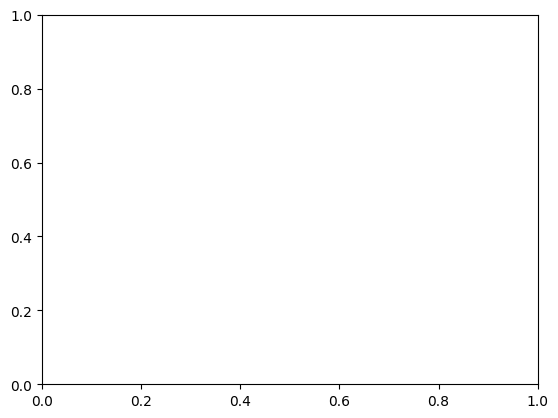

In [34]:
print(energies)
print(fci_energies)
plt.plot(distances, energies, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_energies, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $LiH$')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (7,)

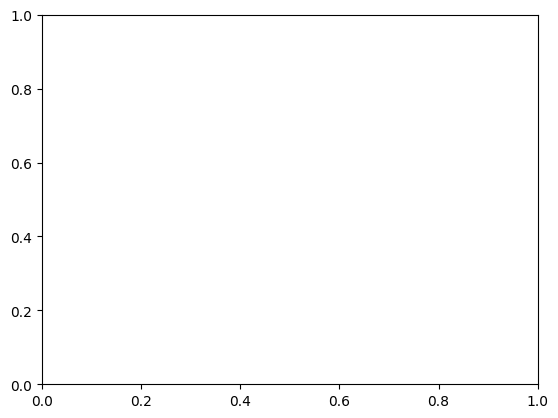

In [35]:
plt.plot(distances, [abs(e - f) for e, f in zip(energies, fci_energies)], marker='o', linestyle='-', label="|UCCSD - FCI|")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy calculation error $LiH$')
plt.show()

[[array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.07243828), array(-13.0

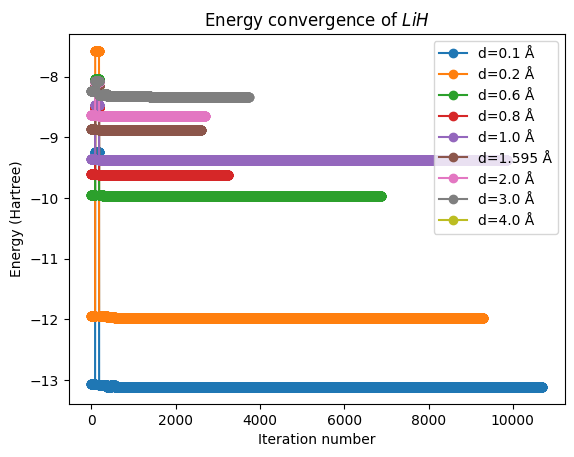

In [36]:
print(iterations)
for i in range(len(distances)):
    plt.plot(range(len(iterations[i])), iterations[i], marker='o', linestyle='-', label=f'd={distances[i]} Å')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Energy (Hartree)')
plt.title('Energy convergence of $LiH$')
plt.show()

[6858.5413069149945, 5695.017285942013, 6388.339810810023, 2095.3139717669983, 6081.105023662996, 1747.4163400109974, 1764.0681546150008]
[0.9482909129874315, 1.0932603630062658, 1.070728668011725, 1.0170216239930596, 1.411874743993394, 0.9020845769846346, 1.1578565800155047, 0.8331611010071356, 1.203765828977339]


ValueError: x and y must have same first dimension, but have shapes (9,) and (7,)

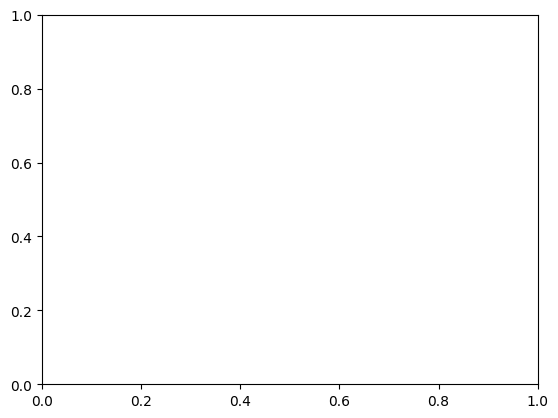

In [37]:
print(runtimes)
print(fci_runtimes)
plt.plot(distances, runtimes, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_runtimes, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.yticks(np.arange(0, max(runtimes) + 1, 0.5))
plt.ylabel('Runtime (s)')
plt.title('$LiH$ runtimes')
plt.show()

## $BeH_2$

In [4]:
distances=[0.1, 0.2, 0.5, 0.7, 1.0, 1.33, 2.0, 3.0, 4.0]
iterations = [[] for _ in range(len(distances))]
runtimes=[]
energies=[]
fci_runtimes=[]
fci_energies=[]

In [7]:
for i in range(len(distances)):
    (qubit_hamiltonian, ansatz) = h_and_uccsd(mapper="JW", molecule_string=molecules[2][1](distances[i]))
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        iterations[i].append(result)
        return result

    initial_point = np.zeros(ansatz.num_parameters)
    start = time.perf_counter()
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    end = time.perf_counter()
    runtimes.append(end - start)
    energies.append(result.fun)

KeyboardInterrupt: 

In [8]:
# FCI
from lib.utils import get_fci_beh2

for i in range(len(distances)):
    start = time.perf_counter()
    fci_energy = get_fci_beh2(distances[i])
    end = time.perf_counter()
    fci_runtimes.append(end - start)
    fci_energies.append(fci_energy)

converged SCF energy = 13.4928033421577
converged SCF energy = -5.20764371334681
converged SCF energy = -13.6461406230644
converged SCF energy = -14.8414384855388
converged SCF energy = -15.4556677731028
converged SCF energy = -15.5600983809979
converged SCF energy = -15.3544173325709
converged SCF energy = -15.0242100060365
converged SCF energy = -14.9345493818235


[]
[np.float64(13.441502018292972), np.float64(-5.266247480067964), np.float64(-13.689960305740966), np.float64(-14.871329754970802), np.float64(-15.481741069507603), np.float64(-15.595117562572968), np.float64(-15.446093740443274), np.float64(-15.336804236060548), np.float64(-15.336821512483452)]


ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

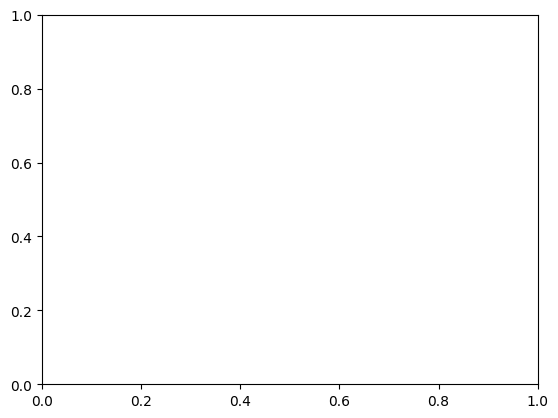

In [9]:
print(energies)
print(fci_energies)
plt.plot(distances, energies, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_energies, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $BeH_2$')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

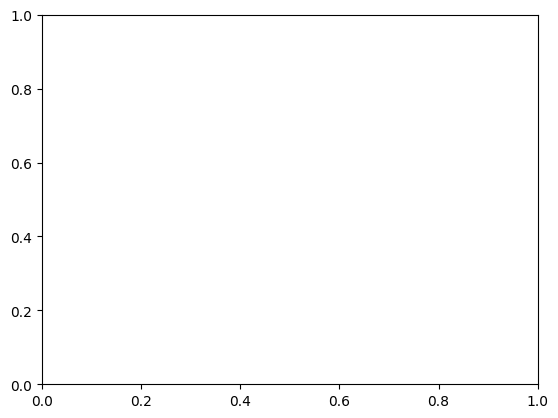

In [10]:
plt.plot(distances, [abs(e - f) for e, f in zip(energies, fci_energies)], marker='o', linestyle='-', label="|UCCSD - FCI|")
plt.legend()
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy calculation error $BeH_2$')
plt.show()

[[array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.48725959), array(-31.4

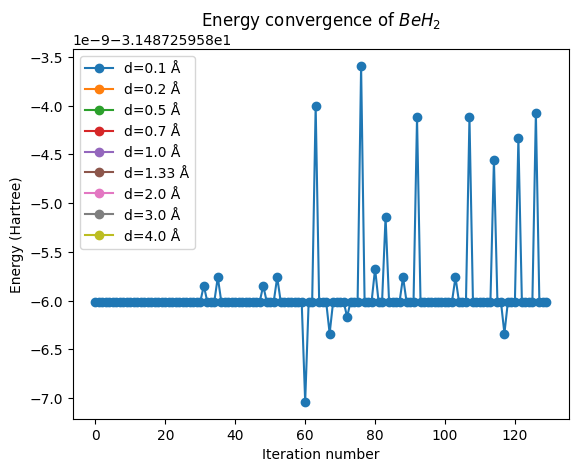

In [11]:
print(iterations)
for i in range(len(distances)):
    plt.plot(range(len(iterations[i])), iterations[i], marker='o', linestyle='-', label=f'd={distances[i]} Å')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Energy (Hartree)')
plt.title('Energy convergence of $BeH_2$')
plt.show()

[]
[0.4010506490000125, 0.25499150400003145, 0.4116107600000305, 0.9549862300000314, 0.24008450299993456, 0.26117932500005736, 0.2510901590000003, 0.2503979220000474, 0.2828930150000133]


ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

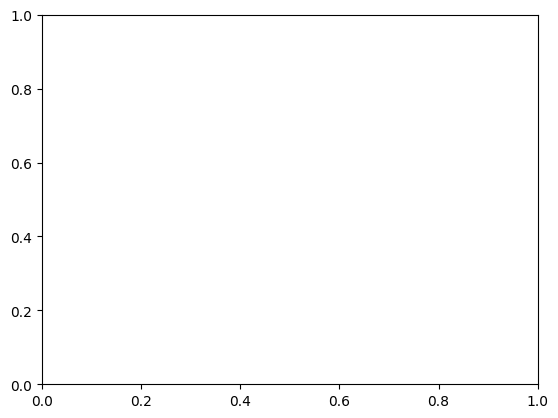

In [12]:
print(runtimes)
print(fci_runtimes)
plt.plot(distances, runtimes, marker='o', linestyle='-', label="UCCSD")
plt.plot(distances, fci_runtimes, marker='o', linestyle='-', label="FCI")
plt.legend()
plt.xlabel('Distances (Å)')
plt.yticks(np.arange(0, max(runtimes) + 1, 0.5))
plt.ylabel('Runtime (s)')
plt.title('$BeH_2$ runtimes')
plt.show()